# PROJET 5 : Segmentez des clients d'un site e-commerce

# SOMMAIRE
## [CONTEXTE DU PROJET](#1)<a class="anchor" id="sommaire"></a>
## [LES DONNEES DU PROJET](#2)<a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#3)<a class="anchor" id="sommaire"></a>
## [CHARGEMENT DES DONNEES](#4)<a class="anchor" id="sommaire"></a>
## [1. ANALYSE INDIVIDUELLE DES DATASETS](#5)<a class="anchor" id="sommaire"></a>
## [2. FUSION ET NETTOYAGE DES DONNEES](#6)<a class="anchor" id="sommaire"></a>
## [3. CLUSTERING METHODE RFM](#7)<a class="anchor" id="sommaire"></a>
## [4. SEGMENTATION CLIENTS AUGMENTEE](#8)<a class="anchor" id="sommaire"></a>
## [5. TEST STABILITE MODELE DANS LE TEMPS](#9)<a class="anchor" id="sommaire"></a>

## [CONTEXTE DU PROJET](#sommaire)<a class="anchor" id="1"></a>

<p>Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.</p>

<p>Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.</p>

<p>Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.</p>

## [LES DONNEES DU PROJET](#sommaire)<a class="anchor" id="2"></a>

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="3"></a>

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import datetime as dt
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
import scipy.stats as sp
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, PowerTransformer, normalize
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier as knn , KNeighborsRegressor as knr
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from functions import *
from math import radians, pi
import json
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## [CHARGEMENT DES DONNEES](#sommaire)<a class="anchor" id="4"></a>

In [2]:
df_cust = pd.read_csv("DATA/olist_customers_dataset.csv")
df_geo = pd.read_csv("DATA/olist_geolocation_dataset.csv")
df_oitem = pd.read_csv("DATA/olist_order_items_dataset.csv")
df_opay = pd.read_csv("DATA/olist_order_payments_dataset.csv")
df_oreview = pd.read_csv("DATA/olist_order_reviews_dataset.csv")
df_odata = pd.read_csv("DATA/olist_orders_dataset.csv")
df_product = pd.read_csv("DATA/olist_products_dataset.csv")
df_seller = pd.read_csv("DATA/olist_sellers_dataset.csv")
df_prod_translate = pd.read_csv("DATA/product_category_name_translation.csv")

## [ANALYSE INDIVIDUELLE DES DATASETS](#sommaire)<a class="anchor" id="6"></a>

In [4]:
df_cust.describe(include="all")

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


In [5]:
df_geo.describe(include="all")

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
count,1.000163e+06,1.000163e+06,1.000163e+06,1000163,1000163
unique,NaN,NaN,NaN,8011,27
top,NaN,NaN,NaN,sao paulo,SP
freq,NaN,NaN,NaN,135800,404268
mean,3.657417e+04,-2.117615e+01,-4.639054e+01,NaN,NaN
std,3.054934e+04,5.715866e+00,4.269748e+00,NaN,NaN
min,1.001000e+03,-3.660537e+01,-1.014668e+02,NaN,NaN
25%,1.107500e+04,-2.360355e+01,-4.857317e+01,NaN,NaN
50%,2.653000e+04,-2.291938e+01,-4.663788e+01,NaN,NaN
75%,6.350400e+04,-1.997962e+01,-4.376771e+01,NaN,NaN


In [6]:
df_geo = df_geo.drop_duplicates(subset = ['geolocation_zip_code_prefix'])

In [7]:
df_oitem.describe(include="all")

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650,112650,112650,112650.000000,112650.000000
unique,98666,NaN,32951,3095,93318,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23,NaN,NaN
freq,21,NaN,527,2033,21,NaN,NaN
mean,NaN,1.197834,NaN,NaN,NaN,120.653739,19.990320
std,NaN,0.705124,NaN,NaN,NaN,183.633928,15.806405
min,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000
25%,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000
50%,NaN,1.000000,NaN,NaN,NaN,74.990000,16.260000
75%,NaN,1.000000,NaN,NaN,NaN,134.900000,21.150000


In [8]:
df_oitem.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [9]:
df_oitem = df_oitem.loc[:, ['order_id', 'order_item_id', 'product_id', 'seller_id']]

In [10]:
df_opay.describe(include="all")

,order_id,payment_sequential,payment_type,payment_installments,payment_value
count,103886,103886.000000,103886,103886.000000,103886.000000
unique,99440,NaN,5,NaN,NaN
top,fa65dad1b0e818e3ccc5cb0e39231352,NaN,credit_card,NaN,NaN
freq,29,NaN,76795,NaN,NaN
mean,NaN,1.092679,NaN,2.853349,154.100380
std,NaN,0.706584,NaN,2.687051,217.494064
min,NaN,1.000000,NaN,0.000000,0.000000
25%,NaN,1.000000,NaN,1.000000,56.790000
50%,NaN,1.000000,NaN,1.000000,100.000000
75%,NaN,1.000000,NaN,4.000000,171.837500


In [11]:
df_opay.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [12]:
df_opay = df_opay.loc[:, ['order_id', 'payment_value']]

In [13]:
df_opay.shape

(103886, 2)

In [14]:
df_opay = df_opay[df_opay['payment_value']!=0]

In [15]:
df_opay.shape

(103877, 2)

In [16]:
df_oreview.describe(include="all")

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,99224,99224,99224.000000,11568,40977,99224,99224
unique,98410,98673,NaN,4527,36159,636,98248
top,7b606b0d57b078384f0b58eac1d41d78,c88b1d1b157a9999ce368f218a407141,NaN,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
freq,3,3,NaN,423,230,463,4
mean,NaN,NaN,4.086421,NaN,NaN,NaN,NaN
std,NaN,NaN,1.347579,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN


In [17]:
df_oreview.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [18]:
df_oreview = df_oreview.loc[:, ['review_id', 'order_id', 'review_score']]

In [19]:
df_oreview['review_score'].unique()

array([4, 5, 1, 3, 2])

In [20]:
df_oreview.shape

(99224, 3)

In [21]:
df_odata.describe(include="all")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [22]:
df_odata.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [23]:
df_odata = df_odata.loc[:,['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']]

In [24]:
df_odata.shape

(99441, 4)

In [25]:
df_odata.groupby(['order_status']).count()

,order_id,customer_id,order_purchase_timestamp
order_status,,,
approved,2,2,2
canceled,625,625,625
created,5,5,5
delivered,96478,96478,96478
invoiced,314,314,314
processing,301,301,301
shipped,1107,1107,1107
unavailable,609,609,609


In [26]:
df_odata = df_odata[df_odata['order_status']=='delivered']

In [27]:
df_odata.shape

(96478, 4)

In [28]:
df_product.describe(include="all")

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951,32341,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
unique,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1e9e8ef04dbcff4541ed26657ea517e5,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,NaN,NaN,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,NaN,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,NaN,NaN,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,NaN,NaN,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,NaN,NaN,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000


In [29]:
df_product.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [30]:
df_product = df_product.iloc[:,:2]

In [31]:
df_seller.describe(include="all")

,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095.000000,3095,3095
unique,3095,NaN,611,23
top,3442f8959a84dea7ee197c632cb2df15,NaN,sao paulo,SP
freq,1,NaN,694,1849
mean,NaN,32291.059451,NaN,NaN
std,NaN,32713.453830,NaN,NaN
min,NaN,1001.000000,NaN,NaN
25%,NaN,7093.500000,NaN,NaN
50%,NaN,14940.000000,NaN,NaN
75%,NaN,64552.500000,NaN,NaN


In [32]:
del df_seller

In [33]:
df_prod_translate.describe(include="all")

,product_category_name,product_category_name_english,Gross_category
count,71,71,71
unique,71,71,10
top,beleza_saude,health_beauty,Loisir
freq,1,1,19


## [FUSION ET NETTOYAGE DES DONNEES](#sommaire)<a class="anchor" id="8"></a>

In [34]:
print(df_cust.shape)
raw_data = pd.merge(df_cust, df_geo, left_on = 'customer_zip_code_prefix', right_on = "geolocation_zip_code_prefix", how = 'left')
del df_geo, df_cust
print(raw_data.shape)
raw_data = pd.merge(raw_data, df_odata, left_on = 'customer_id', right_on = "customer_id", how = 'left')
del df_odata
print(raw_data.shape)
raw_data = pd.merge(raw_data, df_oitem, left_on = 'order_id', right_on = "order_id", how = 'left')
del df_oitem
print(raw_data.shape)
raw_data = pd.merge(raw_data, df_opay, left_on = 'order_id', right_on = "order_id", how = 'left')
del df_opay
print(raw_data.shape)
raw_data = pd.merge(raw_data, df_oreview, left_on = 'order_id', right_on = "order_id", how = 'left')
del df_oreview
print(raw_data.shape)
raw_data = pd.merge(raw_data, df_product, left_on = 'product_id', right_on = "product_id", how = 'left')
del df_product
print(raw_data.shape)
raw_data = pd.merge(raw_data, df_prod_translate, left_on = 'product_category_name', right_on = "product_category_name", how = 'left')
del df_prod_translate
print(raw_data.shape)


(99441, 5)
(99441, 10)
(99441, 13)
(113160, 16)
(117997, 17)
(118682, 19)
(118682, 20)
(118682, 22)


In [35]:
raw_data.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'geolocation_zip_code_prefix',
       'geolocation_lat', 'geolocation_lng', 'geolocation_city',
       'geolocation_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_item_id', 'product_id', 'seller_id',
       'payment_value', 'review_id', 'review_score', 'product_category_name',
       'product_category_name_english', 'Gross_category'],
      dtype='object')

In [36]:
raw_data = raw_data[raw_data['order_purchase_timestamp'].notna()]

In [37]:
l_col = ['order_purchase_timestamp']

for i in l_col:
    print(i)
    raw_data[i] = pd.to_datetime(raw_data[i])


order_purchase_timestamp


In [38]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115719 entries, 0 to 118681
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    115719 non-null  object        
 1   customer_unique_id             115719 non-null  object        
 2   customer_zip_code_prefix       115719 non-null  int64         
 3   customer_city                  115719 non-null  object        
 4   customer_state                 115719 non-null  object        
 5   geolocation_zip_code_prefix    115416 non-null  float64       
 6   geolocation_lat                115416 non-null  float64       
 7   geolocation_lng                115416 non-null  float64       
 8   geolocation_city               115416 non-null  object        
 9   geolocation_state              115416 non-null  object        
 10  order_id                       115719 non-null  object        
 11  

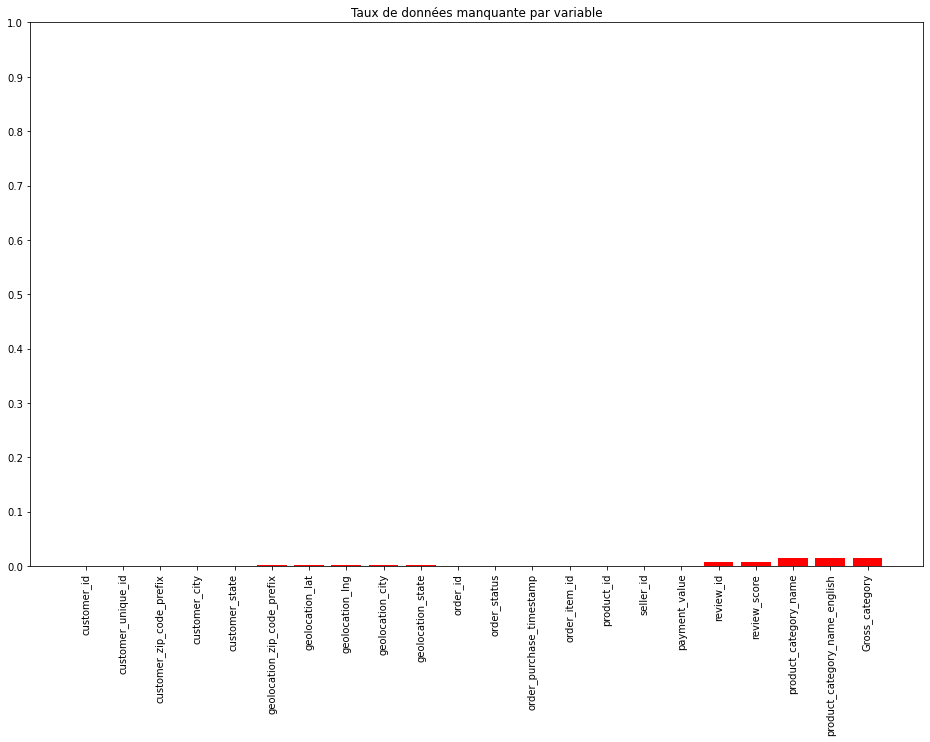

In [39]:
temp_NA_raw = raw_data.isna().mean()

fig, ax = plt.subplots(figsize=(16, 10))
ax.bar(x= temp_NA_raw.index, height =  temp_NA_raw.values, color = "red")
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.05, 0.1))
plt.title("Taux de données manquante par variable")
plt.show()

del temp_NA_raw

In [40]:
temp = raw_data.groupby("customer_unique_id").agg({"order_id":"nunique", "payment_value":"sum"})
temp.describe()

,order_id,payment_value
count,93358.000000,93358.000000
mean,1.033420,212.964557
std,0.209097,646.223866
min,1.000000,0.000000
25%,1.000000,63.830000
50%,1.000000,113.140000
75%,1.000000,202.637500
max,15.000000,109312.640000


In [41]:
temp[temp['order_id'] >1].shape[0] / temp.shape[0]

0.03000278497825575

Seulement 3% des clients ont refait au moins une deuxième commande sur le site

In [42]:
raw_data.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'geolocation_zip_code_prefix',
       'geolocation_lat', 'geolocation_lng', 'geolocation_city',
       'geolocation_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_item_id', 'product_id', 'seller_id',
       'payment_value', 'review_id', 'review_score', 'product_category_name',
       'product_category_name_english', 'Gross_category'],
      dtype='object')

In [43]:
raw_data.groupby('geolocation_state').agg({'customer_unique_id':'count'})

,customer_unique_id
geolocation_state,
AC,94
AL,444
AM,170
AP,83
BA,3938
CE,1494
DF,2260
ES,2311
GO,2385


In [44]:
raw_data['year'] = raw_data['order_purchase_timestamp'].apply(lambda x: x.year)
raw_data['month'] = raw_data['order_purchase_timestamp'].apply(lambda x: x.month)

In [45]:
raw_data.groupby(['year', 'month']).count()

customer_id  customer_unique_id  customer_zip_code_prefix  \
year month                                                              
2016 9                3                   3                         3   
     10             334                 334                       334   
     12               1                   1                         1   
2017 1              981                 981                       981   
     2             1973                1973                      1973   
     3             3098                3098                      3098   
     4             2715                2715                      2715   
     5             4307                4307                      4307   
     6             3726                3726                      3726   
     7             4771                4771                      4771   
     8             5107                5107                      5107   
     9             5040                5040                      5040   
     10            5496                5496                      5496   
     11            8891                8891                      8891   
     12            6469                6469                      6469   
2018 1             8417                8417                      8417   
     2             7864                7864                      7864   
     3             8384                8384                      8384   
     4             8123                8123                      8123   
     5             8113                8113                      8113   
     6             7327                7327                      7327   
     7             7223                7223                      7223   
     8             7356                7356                      7356   

            customer_city  customer_state  geolocation_zip_code_prefix  \
year month                                                               
2016 9                  3               3                            3   
     10               334             334                          334   
     12                 1               1                            1   
2017 1                981             981                          981   
     2               1973            1973                         1973   
     3               3098            3098                         3091   
     4               2715            2715                         2709   
     5               4307            4307                         4295   
     6               3726            3726                         3709   
     7               4771            4771                         4763   
     8               5107            5107                         5088   
     9               5040            5040                         5028   
     10              5496            5496                         5483   
     11              8891            8891                         8869   
     12              6469            6469                         6451   
2018 1               8417            8417                         8402   
     2               7864            7864                         7837   
     3               8384            8384                         8361   
     4               8123            8123                         8101   
     5               8113            8113                         8092   
     6               7327            7327                         7307   
     7               7223            7223                         7204   
     8               7356            7356                         7334   

            geolocation_lat  geolocation_lng  geolocation_city  \
year month                                                       
2016 9                    3                3                 3   
     10                 334              334               334   
     12                   1                1                 1   
2017 

In [46]:
raw_data = raw_data[raw_data['year'] != 2016]

In [47]:
temp = raw_data.loc[:, ['customer_unique_id','order_purchase_timestamp']].groupby('customer_unique_id')

In [48]:
#temp1 = temp.apply(lambda x: (x.max()-x.min())/x.count())

In [49]:
#temp1[temp1['order_purchase_timestamp']>pd.Timedelta(1, unit="d")]

In [50]:
#temp1.columns = ['Frequency']

In [51]:
rfm = raw_data.groupby('customer_unique_id').agg({'order_purchase_timestamp':'last','order_id':'count', 'payment_value':'sum'}) 


In [52]:
#rfm = pd.merge(rfm, temp1, left_on = 'customer_unique_id', right_on='customer_unique_id', how='inner')

In [53]:
rfm.columns = ['Recent', 'Frequency', 'Mount']
rfm['Recent'] = raw_data['order_purchase_timestamp'].max() - rfm['Recent']
rfm['Recent'] = rfm['Recent'].apply(lambda x: x.days)

In [54]:
#rfm['Frequency'] = rfm['Frequency'].apply(lambda x: x.days)

In [55]:
rfm[(rfm['Frequency']>40)|(rfm['Mount']>50000)]

,Recent,Frequency,Mount
customer_unique_id,,,
0a0a92112bd4c708ca5fde585afaa872,333,8,109312.64
9a736b248f67d166d2fbb006bcb877c3,398,75,556.13


In [56]:
mask = rfm[(rfm['Frequency']>40)|(rfm['Mount']>50000)].index
rfm = rfm.drop(mask)

In [57]:
raw_data = raw_data[(raw_data['customer_unique_id'] != mask[0]) & (raw_data['customer_unique_id'] != mask[1])]

In [58]:
rfm.to_csv("DATA/rfm.csv")
raw_data.to_csv("DATA/raw_data.csv")